<a href="https://colab.research.google.com/github/manu6521/Image_project/blob/main/Copy_of_image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import modules


In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,LSTM,Dense,Embedding,Dropout,concatenate
from tensorflow.keras.layers import add
from tensorflow.keras.layers import Reshape
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu

In [2]:
#pip install pydot

In [3]:

#pip install pydot graphviz

In [4]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!mkdir -p /content/flickr_new


In [6]:
!unzip '/content/drive/MyDrive/flicker/Flickr8k_Dataset.zip' -d /content/flickr_new


Streaming output truncated to the last 5000 lines.
  inflating: /content/flickr_new/__MACOSX/Flicker8k_Dataset/._342872408_04a2832a1b.jpg  
  inflating: /content/flickr_new/Flicker8k_Dataset/3429142249_d09a32e291.jpg  
  inflating: /content/flickr_new/__MACOSX/Flicker8k_Dataset/._3429142249_d09a32e291.jpg  
  inflating: /content/flickr_new/Flicker8k_Dataset/3429194423_98e911a101.jpg  
  inflating: /content/flickr_new/__MACOSX/Flicker8k_Dataset/._3429194423_98e911a101.jpg  
  inflating: /content/flickr_new/Flicker8k_Dataset/3429351222_17ae744daf.jpg  
  inflating: /content/flickr_new/__MACOSX/Flicker8k_Dataset/._3429351222_17ae744daf.jpg  
  inflating: /content/flickr_new/Flicker8k_Dataset/3429351964_531de1bf16.jpg  
  inflating: /content/flickr_new/__MACOSX/Flicker8k_Dataset/._3429351964_531de1bf16.jpg  
  inflating: /content/flickr_new/Flicker8k_Dataset/3429391520_930b153f94.jpg  
  inflating: /content/flickr_new/__MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: /c

In [7]:
dir_new = '/content/flickr_new/Flicker8k_Dataset/'
dir_cap = '/content/flickr_new/'

In [8]:
#printing number of images
df = os.listdir(dir_new)
print(len(df))

8091


In [9]:
#model
model = VGG16()
model = Model(inputs = model.inputs,outputs = model.layers[-2].output)
print(model.summary())


553467096/553467096 [==============================] - 18s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [10]:
#extract features from image
features = { }
for img_name in tqdm(os.listdir(dir_new)):
  #load image from file
  image_path = dir_new + '/' + img_name
  image = load_img(image_path, target_size=(224,224))
  # convert image pixels to numpy array
  image = img_to_array(image)
  #reshape data for model
  image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
  #preprocess image for vgg16
  image = preprocess_input(image)
  #extract feature
  feature = model.predict(image,verbose=0)
  #get image id
  image_id = img_name.split('.')[0]
  #store features
  features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [11]:

#store features in pickle
pickle.dump(features, open(os.path.join(dir_new, 'ex_features.pkl'), 'wb'))

In [12]:
# load feature from pickle
with open(os.path.join(dir_new, 'ex_features.pkl'), 'rb') as f:
  ex_features = pickle.load(f)


In [13]:
#### TESTING

def print_image_features(features_dict):
    for key, value in features_dict.items():
        print(f"Image ID: {key}")
        print(f"Features: {value}")
        print(f"Feature shape: {np.array(value).shape}")
        print("-" * 50)

# Print the values in the dictionary
#print_image_features(ex_features)

In [14]:
!unzip '/content/drive/MyDrive/captions.txt.zip' -d /content/flickr_new

Archive:  /content/drive/MyDrive/captions.txt.zip
  inflating: /content/flickr_new/captions.txt  


In [15]:
with open(os.path.join(dir_cap, 'captions.txt'), 'r') as f:
  next(f)
  captions_doc = f.read()




In [16]:
#create mapping of images to captions
mapping = { }
# process line
for line in tqdm(captions_doc.split('\n')):
#split line by comma
  tokens = line.split(',')
  if len(line)<2:
    continue
  image_id, caption = tokens[0], tokens[1:]
  #remove extension from image id
  image_id = image_id.split('.')[0]
  # convert caption list to a string
  caption = " ".join(caption)
  # create list if needed
  if image_id not in mapping:
    mapping[image_id] = []
  mapping[image_id].append(caption)

print(mapping[image_id])

  0%|          | 0/40456 [00:00<?, ?it/s]

['A man in a pink shirt climbs a rock face', 'A man is rock climbing high in the air .', 'A person in a red shirt climbing up a rock face covered in assist handles .', 'A rock climber in a red shirt .', 'A rock climber practices on a rock climbing wall .']


In [17]:
# preprocess caption
def clean_cap(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      caption = captions[i]
      # convert to lowercase
      caption = caption.lower()
      # deleting special chars, digits
      caption = caption.replace('[^A-Za-z]','')
      # removing additional spaces
      caption = caption.replace('\s+',' ')
      # add <start> and <end> tag
      caption = " ".join([word for word in caption.split() if len(word)>1])
      caption = 'start ' + caption + ' end'
      captions[i] = caption




In [18]:
# before preprocess
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [19]:
# calling cleaning function
clean_cap(mapping)

In [20]:
# after preprocessing
mapping['1000268201_693b08cb0e']

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

In [21]:
# saving all the caption in single list
final_captions = []
for key in mapping:
  for caption in mapping[key]:
    final_captions.append(caption)

In [22]:
len(final_captions)

40455

In [23]:
# text tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(final_captions)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

8483


In [24]:
#findimg maximum length of caption
length_max = max(len(caption.split()) for caption in final_captions)
length_max

35

## Train_test_split

In [25]:
# taking image ids
image_ids = list(mapping.keys())
split = int(len(image_ids) *0.90)
train = image_ids[:split]
test  = image_ids[split:]

In [26]:
# length of dataset
print('Length of training data:' + str(len(train)))
print('Length of test data:' + str(len(test)))


Length of training data:7281
Length of test data:810


In [27]:
## Create generator to get data in batch

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        X1, X2, y = [], [], []
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    # Split the sequence into input and output pairs
                    input_seq, output_seq = seq[:i], seq[i]
                    # Pad the input sequence to max_length
                    input_seq = pad_sequences([input_seq], maxlen=max_length)[0]
                    # One-hot encode the output sequence
                    output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]
                    # Store the sequences
                    X1.append(features[key][0])
                    X2.append(input_seq)
                    y.append(output_seq)
                    # Yield a batch of data
                    if len(X1) == batch_size:
                        yield [np.array(X1), np.array(X2)], np.array(y)
                        X1, X2, y = [], [], []



In [28]:
generator = data_generator(train,mapping,ex_features,tokenizer,length_max,vocab_size,64)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

(64, 4096)
(64, 35)
(64, 8483)


## CREATING MODEL

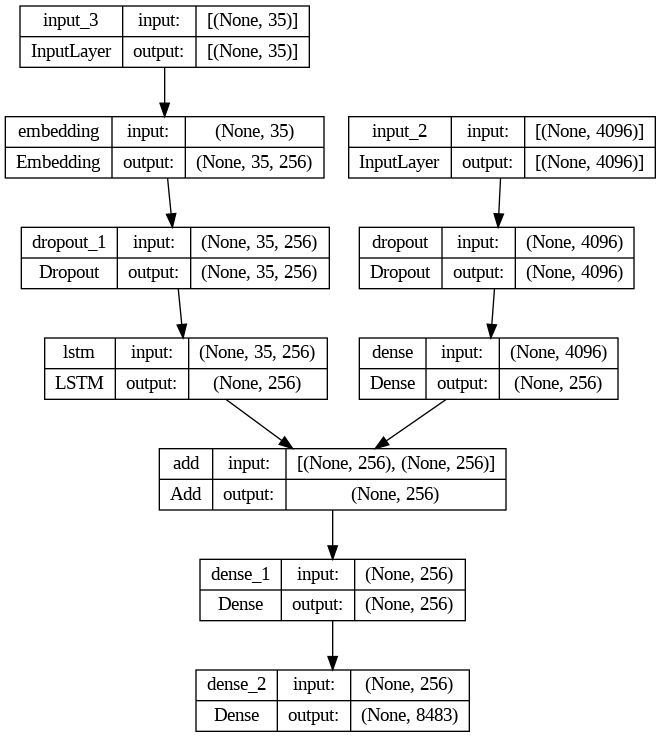

In [29]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)


inputs2 = Input(shape = (length_max,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)


decoder1 = add([fe2, se3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)


model = Model(inputs=[inputs1,inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')


plot_model(model, show_shapes=True)


In [30]:
epochs = 35
batch_size = 64
steps = len(train)/batch_size
for i in range(epochs):
  generator = data_generator(train,mapping,ex_features,tokenizer,length_max,vocab_size,batch_size)
  model.fit(generator, epochs=1,steps_per_epoch=steps, verbose=1)

113/113 [==============================] - 7s 65ms/step - loss: 1.0553


In [31]:
## Saving the model

model.save(dir_cap+'/model2.keras')

In [32]:
## converting index to word
def ind_to_word(integer,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None





In [44]:
# generating captions
def predict_caption(model, image, tokenizer, length_max):
  in_text = 'start'
  for i in range(length_max):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], length_max)
    yhat = model.predict([image, sequence], verbose=0)

    yhat = np.argmax(yhat)

    word = ind_to_word(yhat,tokenizer)
    if word is None:
      break

    in_text += " " + word
    if word == 'end':
      break
  return in_text





In [45]:
# validating

actual, predicted = list(), list()

for key in tqdm(test):
  captions = mapping[key]
  y_pred = predict_caption(model, ex_features[key], tokenizer, length_max)
  actual_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()
  actual.append(actual_captions)
  predicted.append(y_pred)


print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.485083
BLEU-2: 0.248703


In [36]:
## Visualize

In [50]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_captions(image_name):
  #image_name = "1000268201_693b08cb0e"
  image_id = image_name.split('.')[0]
  image_path = image_path = os.path.join(dir_new, image_name)
  image = Image.open(image_path)
  captions = mapping[image_id]
  print('..............Actual...........')
  for caption in captions:
    print(caption)

  y_pred = predict_caption(model, features[image_id], tokenizer, length_max)
  print('...............Predicted..............')
  print(y_pred)
  plt.imshow(image)


..............Actual...........
start black dog carries green toy in his mouth as he walks through the grass end
start black dog carrying something through the grass end
start black dog has blue toy in its mouth end
start dog in grass with blue item in his mouth end
start wet black dog is carrying green toy through the grass end
...............Predicted..............
start black dog carrying green toy through the grass end


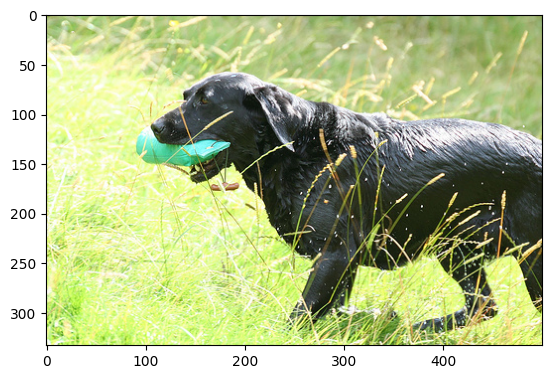

In [53]:
generate_captions('1026685415_0431cbf574.jpg')

..............Actual...........
start two constructions workers sit on beam taking break end
start two construction workers are sitting up on the side of building end
start two construction workers sitting on an i-beam end
start two construction workers take seat on steel beam end
start two men take break from construction end
...............Predicted..............
start two constructions workers take seat take break from construction end


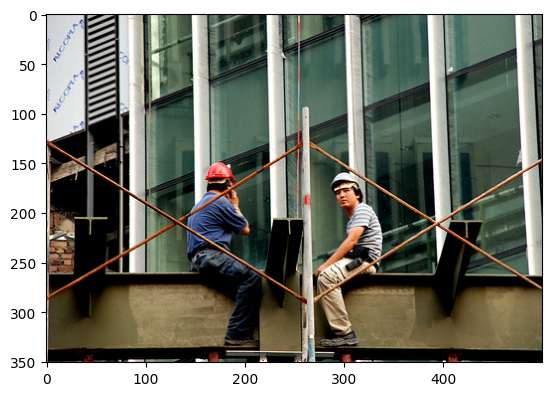

In [54]:
generate_captions('1055753357_4fa3d8d693.jpg')

..............Actual...........
start man in wetsuit is throwing baby wearing wetsuit up into the air end
start man in wetsuit is throwing toddler up in the air and is ready to catch him end
start man in water throwing little boy up in the air and waiting for him to come down so he can catch him end
start the man is in the pool and throwing small boy into the air end
start "while water droplets fly man throws little boy up in the air ." end
...............Predicted..............
start man in wetsuit is throwing toddler up into the pool end


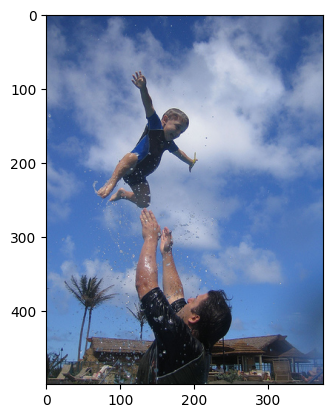

In [55]:
generate_captions('1077931201_1e0bb83105.jpg')

..............Actual...........
start person on snowmobile in mid jump end
start snowmobiler flies through the air end
start snowmobile rider flies through the air on his or her machine in front of tall pine trees end
start rider jumps snowmobile high in rural area end
start the man is up in the air end
...............Predicted..............
start the man jumps through the air in the air end


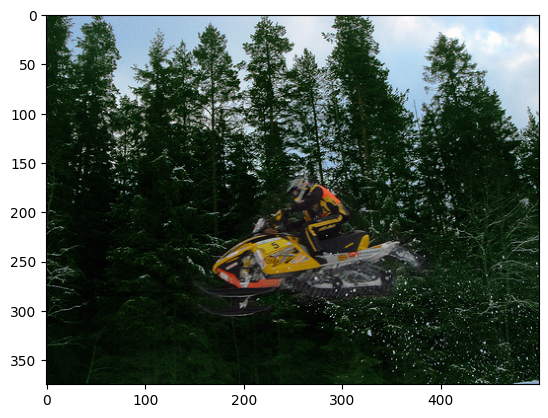

In [56]:
generate_captions('109738763_90541ef30d.jpg')